In [1]:
library('tidyverse')
library('rvest')
library('lubridate')
library('ggrepel')
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 6)

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘lubridate’


In [2]:
scrape_table = function(i, MF='Women\'s') {
    url = "https://www.baa.org/races/boston-marathon/results/champions"
    webpage = xml2::read_html(url)
    tbl = html_nodes(webpage, "table")[[i]] %>%
        html_table() %>%
        drop_na() %>%
        magrittr::set_colnames(c('year', 'name', 'country', 'time')) %>%
        mutate(time = hms(time)) %>%
        mutate(race.time = as.numeric(time, 'hours')) %>%
        mutate(MF = MF) %>%
        mutate(
            country.simple = ifelse(
                country %in% c('United States', 'Ethiopia', 'Japan', 'Kenya'),
                country,
                'other'
            )
        )
    tbl
}

df.men = scrape_table(1, MF='Men\'s')
df.women = scrape_table(2)

df.marathon = rbind(df.men, df.women)

Let's re-create this chart from FiveThirtyEight

<center>
    <img src="https://fivethirtyeight.com/wp-content/uploads/2018/04/wezerek-marathon-0416-13.png"
         style="width: 600px;"/>
</center>

Preview the data (i.e. `df.marathon`).

In [3]:
df.marathon %>% head

,year,name,country,time,race.time,MF,country.simple
,<int>,<chr>,<chr>,<Period>,<dbl>,<chr>,<chr>
1,2019,Lawrence Cherono,Kenya,2H 7M 57S,2.132500,Men's,Kenya
2,2018,Yuki Kawauchi,Japan,2H 15M 58S,2.266111,Men's,Japan
3,2017,Geoffrey Kirui,Kenya,2H 9M 37S,2.160278,Men's,Kenya
4,2016,Lemi Berhanu,Ethiopia,2H 12M 45S,2.212500,Men's,Ethiopia
5,2015,Lelisa Desisa,Ethiopia,2H 9M 17S,2.154722,Men's,Ethiopia
6,2014,"Mebrahtom ""Meb"" Keflezighi",United States,2H 8M 37S,2.143611,Men's,United States


Fill in the table below:

| chart property | column name |
| --- | --- |
| x value | year |
| y value | ? |
| color | ? |
| facet value | ? |

Make note of other aesthetic decisions. 
- What's the y-axis title?
- Do the two charts share the same x-axis bounds?
- Is there a legend?

Code your version of the chart below.

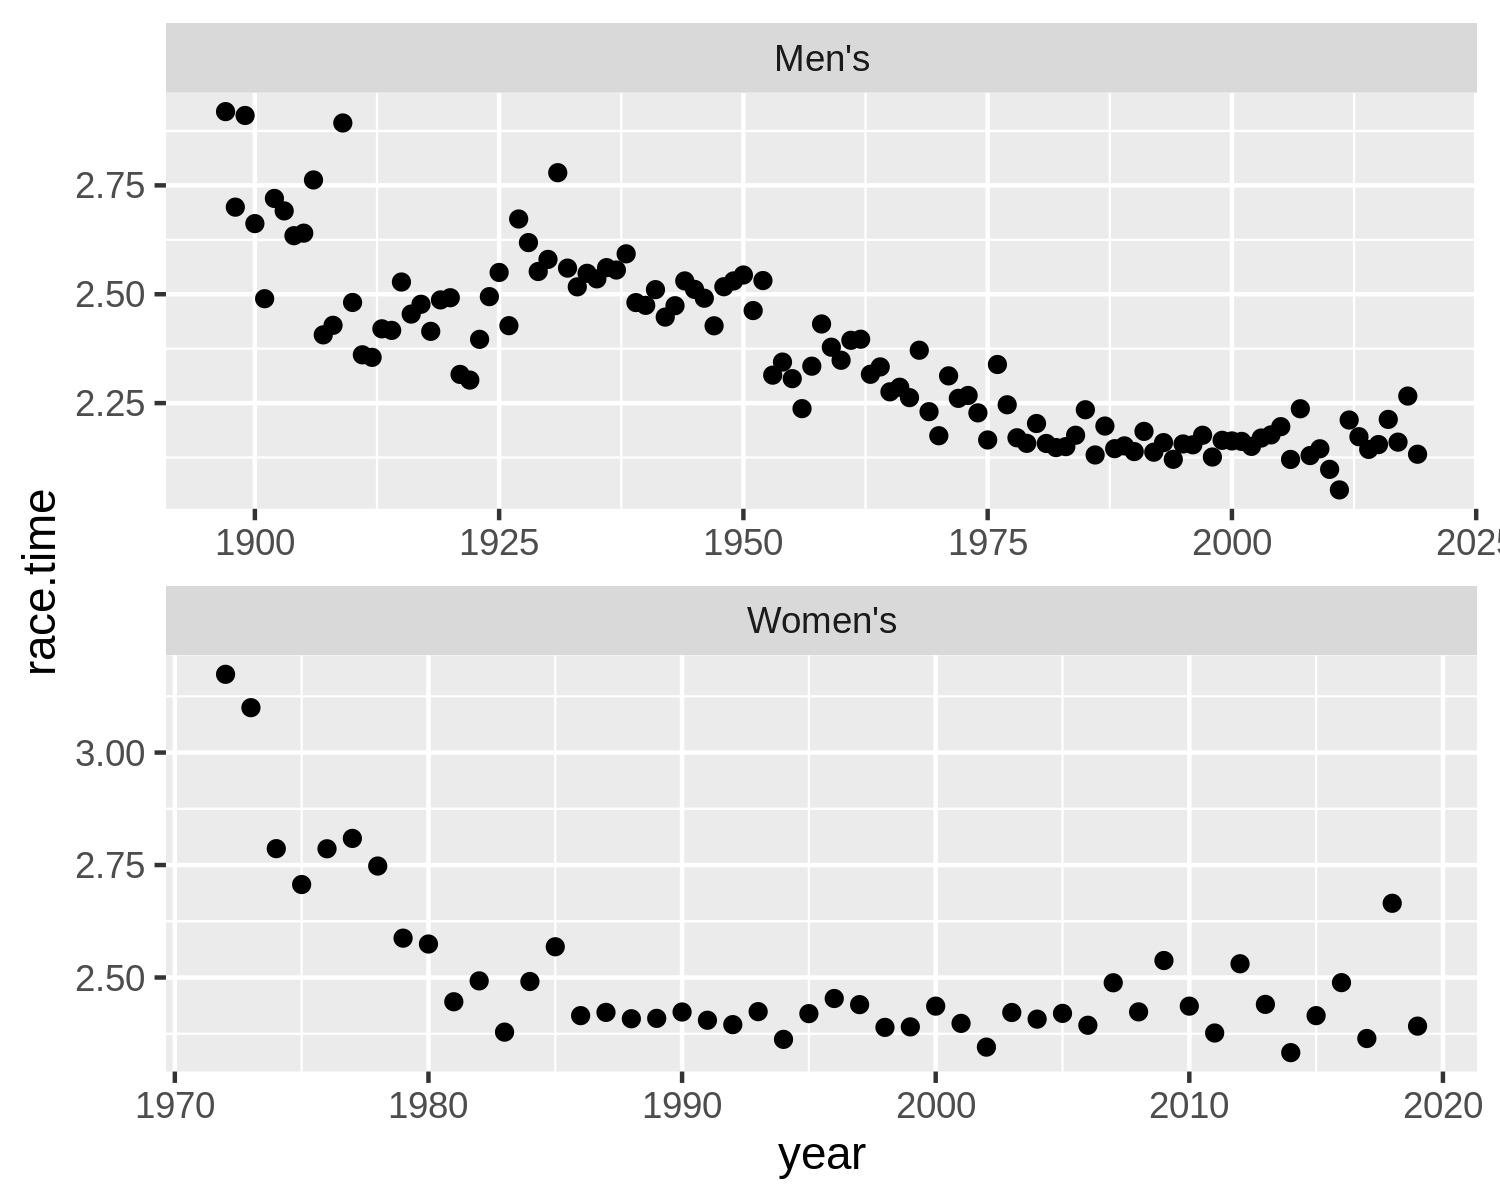

In [4]:
options(repr.plot.res = 300, repr.plot.width = 5, repr.plot.height = 4)
ggplot(data = df.marathon) + 
  geom_point(aes(x = year, y = race.time)) + 
  facet_wrap(~MF, scales = 'free',ncol = 1) 

Why did they choose to highlight those categories?

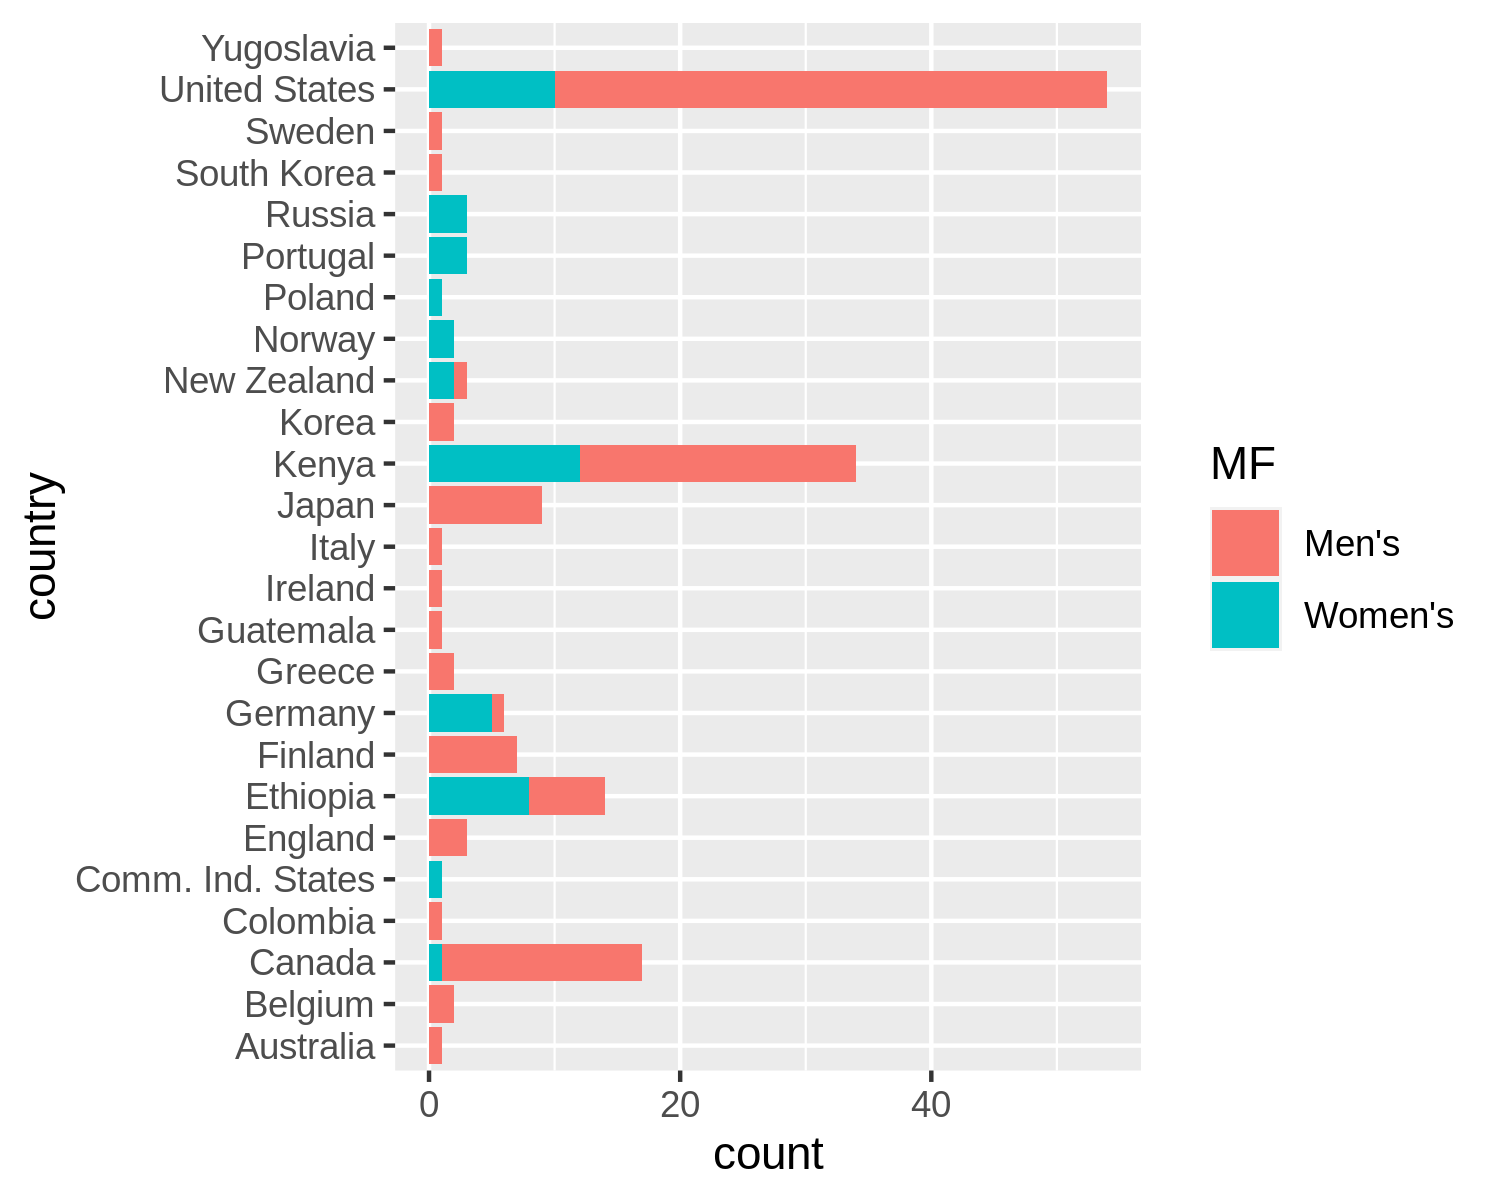

In [5]:
#choose the countries that had the greatest number of winners
ggplot(df.marathon, aes(y = country, fill = MF)) + 
  geom_bar() 

In [6]:
#first need to take averages of each country of interest to specify y value of where the name will go on the plot
df.country = df.marathon %>%
    filter(country %in% c('United States', 'Kenya', 'Ethiopia', 'Japan')) %>%
    group_by(country, MF) %>%
    summarize(race.time = mean(race.time), year = mean(year)) 
df.country

`summarise()` regrouping output by 'country' (override with `.groups` argument)



country,MF,race.time,year
<chr>,<chr>,<dbl>,<dbl>
Ethiopia,Men's,2.172083,2007.833
Ethiopia,Women's,2.411597,2007.625
Japan,Men's,2.277315,1971.667
Kenya,Men's,2.151086,2001.909
Kenya,Women's,2.422199,2007.917
United States,Men's,2.474678,1935.091
United States,Women's,2.760250,1981.500


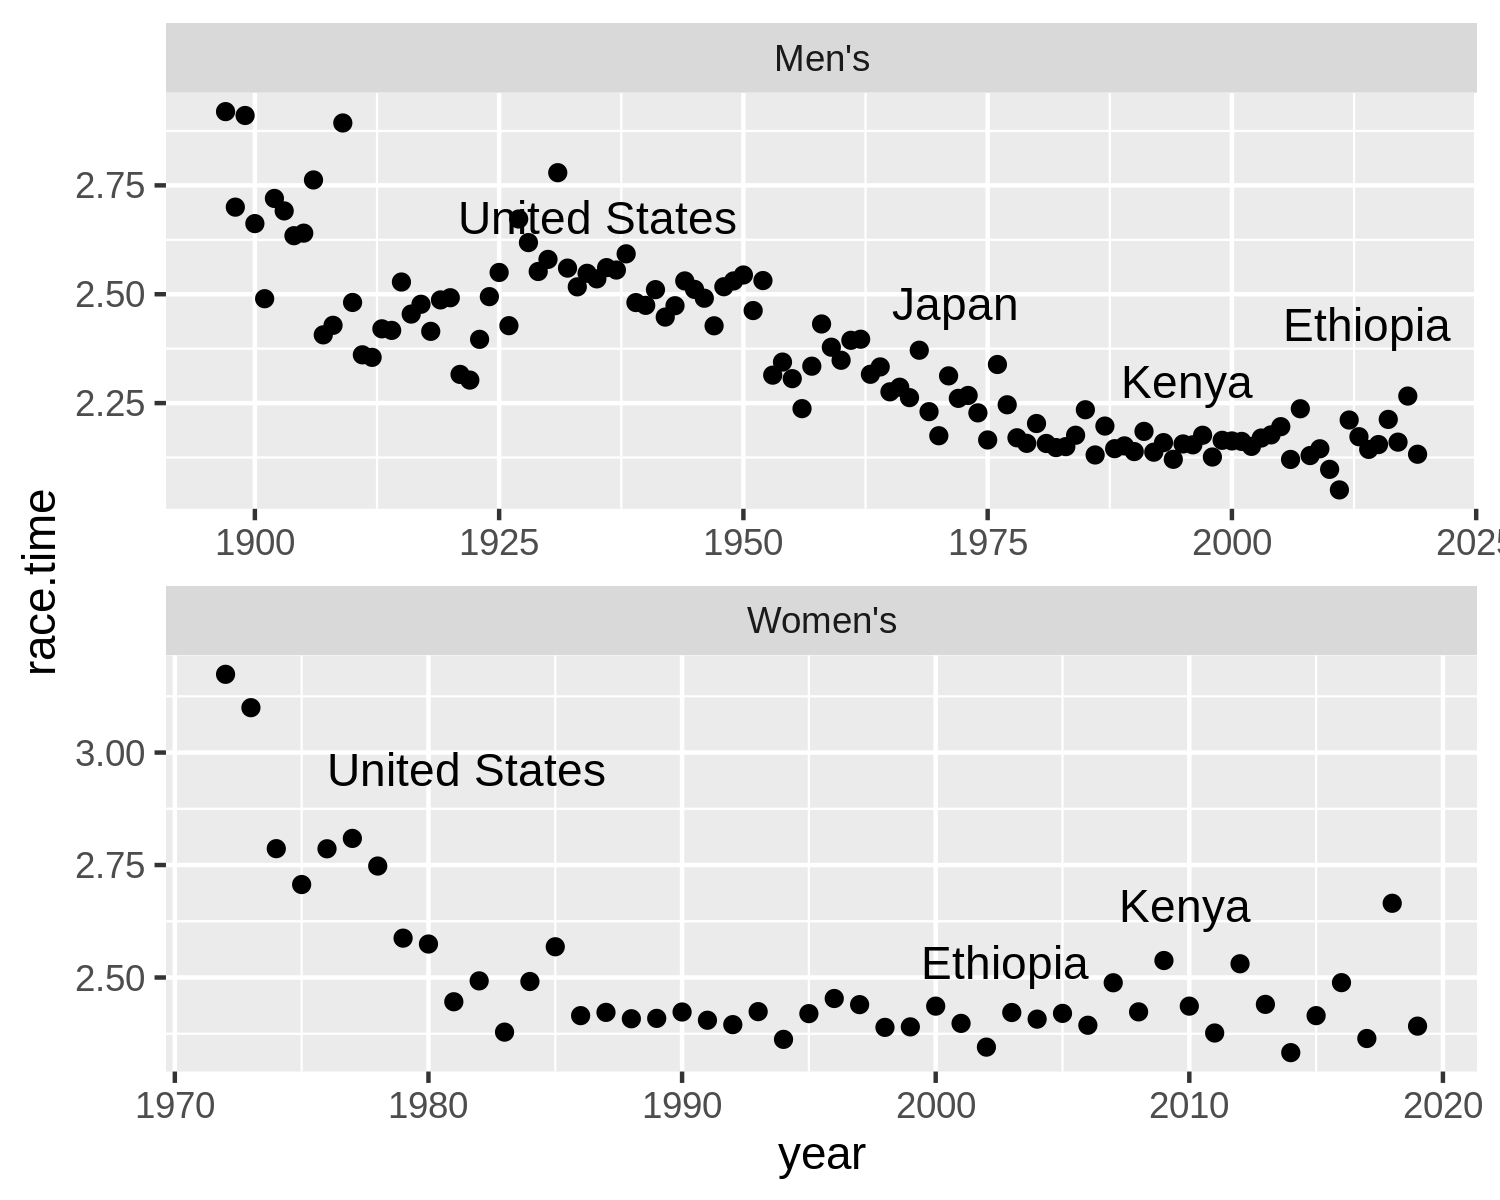

In [12]:
options(repr.plot.res = 300, repr.plot.width = 5, repr.plot.height = 4)
ggplot(data = df.marathon, aes(x = year, y = race.time)) + 
  geom_point() + 
  geom_text_repel(
      segment.color = 'transparent', #removes line segment
      nudge_y = 0.2,
      data = df.country, 
      aes(label = country)) +
  facet_wrap(~MF, scales = 'free',ncol = 1) 

Now we're closer, but we need these countries in a different color.

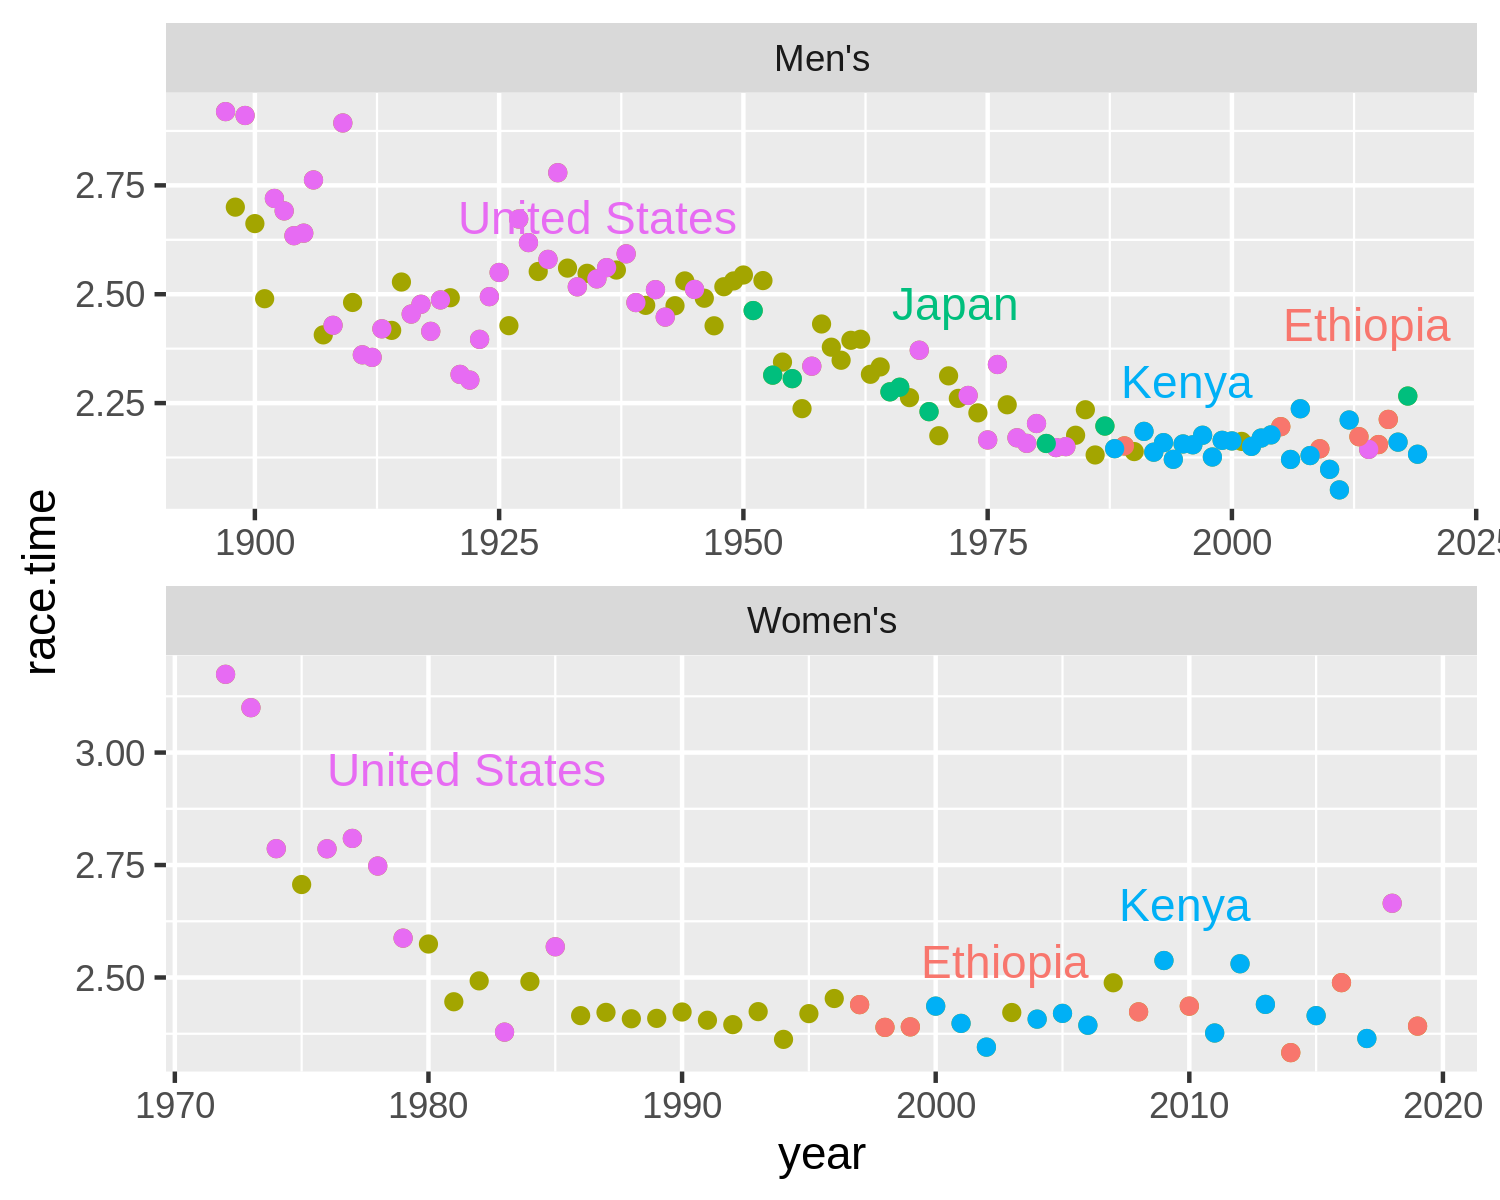

In [17]:
df.filtered = df.marathon %>% 
    filter(country %in% c('United States', 'Kenya', 'Ethiopia', 'Japan'))
ggplot(data = df.marathon, aes(x = year, y = race.time)) + 
  geom_point(aes(color = 'gray50')) + #plots all countries we're not interested in 
  geom_point(data = df.filtered, aes(color = country)) +#doing this to color countries we are interested in
  geom_text_repel(
      segment.color = 'transparent', #removes line segment
      nudge_y = 0.2,
      data = df.country, 
      aes(label = country, color = country)) +
  facet_wrap(~MF, scales = 'free',ncol = 1) + 
  theme(legend.position = 'none') #removing legend

What else might you visualize with this data? (e.g. What about totaling the winners from each country?)